<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/%EC%9D%B4%EB%AF%B8%EC%A7%80%20%EB%B3%B5%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal
    - noisy가 있는 fashion MNIST 이미지 원래대로 복구
    - 흑백이미지와 컬러 이미지의 차이
    - 이미지에 noisy 추가
    - 이미지에 대한 autoencoder식 접근방법
    

In [1]:
# Load the package
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
seed = 34

In [2]:
# Load the dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels) , (test_images, test_labels) = fashion_mnist.load_data()
print(train_images.shape)
print(test_labels.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000,)


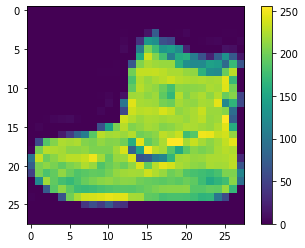

In [3]:
# 이미지 출력

plt.imshow(train_images[0])
plt.colorbar()
plt.show()

In [4]:
# 0이 아닌 값들을 확인

list(filter(lambda x : x != 0, train_images[0].reshape(-1)))[:10]


[1, 13, 73, 1, 4, 1, 1, 3, 36, 136]

## Pre-processing
    

In [5]:
# 0-1 normailzie scaling
train_images = train_images / 255
test_images = test_images / 255

In [6]:
print(min(train_images.reshape(-1)), max(train_images.reshape(-1)))

0.0 1.0


In [7]:
# gray-scale shape -> color map shape

from skimage import color
print(f'train_images shape : {train_images[0].shape}')
print(f"gray2rgb's shape : {color.gray2rgb(train_images[0]).shape}")

train_images shape : (28, 28)
gray2rgb's shape : (28, 28, 3)


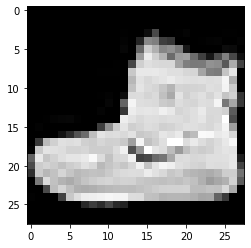

In [8]:
plt.imshow(color.gray2rgb(train_images[0]))
plt.show()

In [9]:
train_images = np.array([color.gray2rgb(img) for img in train_images])
test_images = np.array([color.gray2rgb(img) for img in test_images])
print(train_images.shape, test_images.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


## Visualization
    

In [10]:
# Using 5 train_images

train_images[:5].shape

(5, 28, 28, 3)

In [11]:
# image shape change : (5,28,28,3 ) -> (28, 28*5, 3)
np.hstack(train_images[:5]).shape

(28, 140, 3)

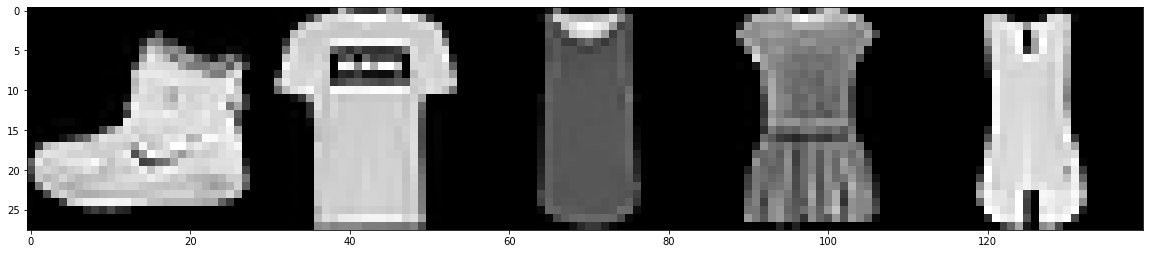

In [12]:
plt.figure(figsize=(20,5))
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [13]:
# Another Method (recommend)
print(train_images[:5].shape)
print(train_images[:5].transpose( (1, 0, 2, 3)  ).shape) # (orignal : 0 , 1, 2, 3) -> (changed : 1, 0, 2, 3)
print(train_images[:5].transpose( (1, 0, 2, 3)  ).reshape((28,-1,3)).shape)

(5, 28, 28, 3)
(28, 5, 28, 3)
(28, 140, 3)


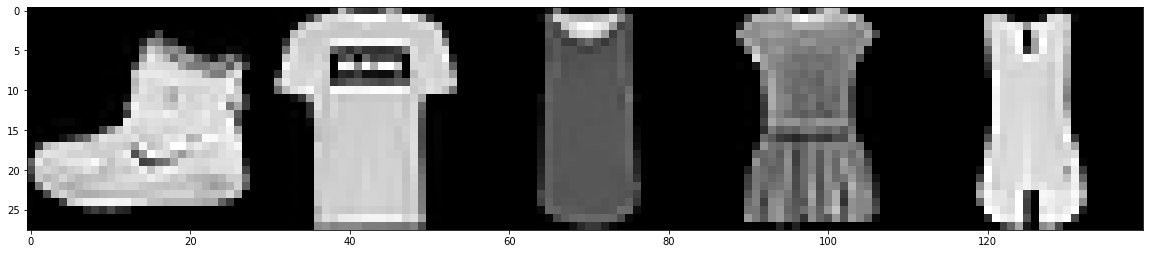

In [14]:
plt.figure(figsize=(20,5))
plt.imshow(train_images[:5].transpose( (1, 0, 2, 3)  ).reshape((28,-1,3)))
plt.show()

## Add noisy
    

In [15]:
np.random.random()

0.30615662813548605

In [16]:
# (28,28,3)의 noise 생성
np.random.random((28,28,3)).shape

(28, 28, 3)

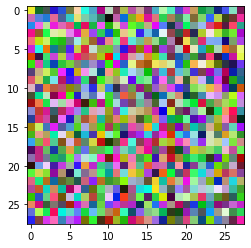

In [17]:
plt.imshow(np.random.random((28,28,3)))
plt.show()

In [18]:
# Gaussian noise
np.random.normal(0,0.1,3)

array([ 0.26903345, -0.12747673,  0.06076525])

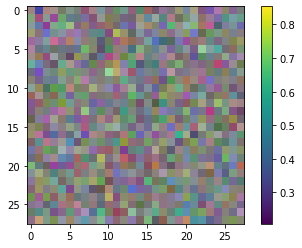

In [19]:
noise = np.random.normal(0.5, 0.1, (28,28,3))
plt.imshow(noise)
plt.colorbar()
plt.show()

In [20]:
# Adding 'noise' to #.5 images 
print(train_images[5].shape)
print(noise.shape)
print((train_images[5] + noise).shape)

(28, 28, 3)
(28, 28, 3)
(28, 28, 3)


In [21]:
noise_image = train_images[5] + noise
print(min(noise_image.reshape(-1)), max(noise_image.reshape(-1)))
noise_image[noise_image > 1 ] = 1.0
print(max(noise_image.reshape(-1)))

0.23013715180818234 1.7049868859747392
1.0


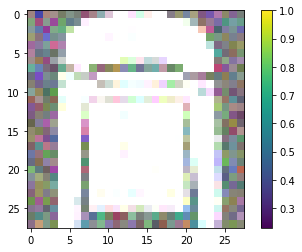

In [22]:
plt.imshow(noise_image)
plt.colorbar()
plt.show()

In [23]:
# Adding 'noise' to Entire dataset
train_images.shape

(60000, 28, 28, 3)

In [24]:
train_noisy_images = train_images + np.random.normal(0.5, 0.2, train_images.shape)
train_noisy_images[train_noisy_images > 1] = 1
test_noisy_images = test_images + np.random.normal(0.5, 0.2, test_images.shape)
test_noisy_images[test_noisy_images > 1] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


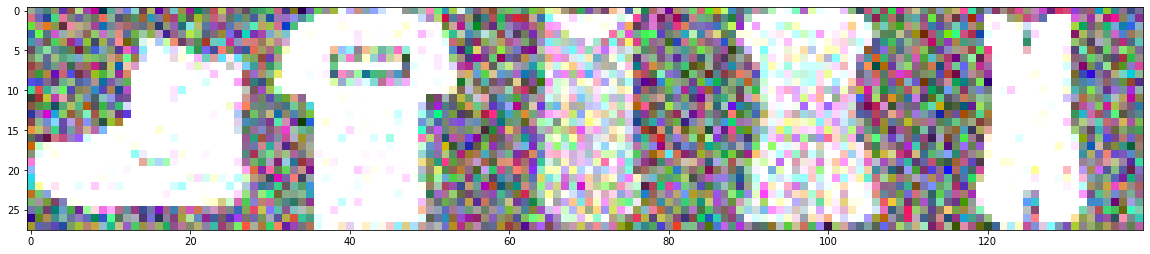

In [25]:
# Checking the noise_images
plt.figure(figsize=(20,5))
plt.imshow(train_noisy_images[:5].transpose( (1, 0, 2, 3)  ).reshape((28,-1,3)))
plt.show()

## Modeling

``` 
 -  image denoising model
 -  Autoencoder
```

In [ ]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
'''
autoencoder : 28x28 짜리가 점점 작아지다가 커지는 모래시계형 구조
'''
inputs = Input(shape=(28, 28, 3))
x = Conv2D(32, kernel_size = 3, strides= 2, activation = 'relu', padding='same')(inputs)
x = Conv2D(64, kernel_size = 3, strides= 2, activation = 'relu', padding='same')(x)
x = Flatten()(x) # 여기까지가 작아지는 부분
latent = Dense(10)(x) # 1차원 벡터로 바꿈

x = Dense(7*7*64)(latent)
x = Reshape((7,7,64))(x) # CNN에서 뱉어낸 형태로 바꿔줌
x = Conv2DTranspose(64, 3, 2, activation = 'relu', padding='same')(x)
x = Conv2DTranspose(32, 3, 2, activation = 'relu', padding='same')(x)
x = Conv2DTranspose(3, 3, activation = 'sigmoid', padding='same')(x)

model = Model(inputs, x)

## Goal
    - noisy가 있는 fashion MNIST 이미지 원래대로 복구
    - 흑백이미지와 컬러 이미지의 차이
    - 이미지에 noisy 추가
    - 이미지에 대한 autoencoder식 접근방법
    

## Goal
    - noisy가 있는 fashion MNIST 이미지 원래대로 복구
    - 흑백이미지와 컬러 이미지의 차이
    - 이미지에 noisy 추가
    - 이미지에 대한 autoencoder식 접근방법
    

## Goal
    - noisy가 있는 fashion MNIST 이미지 원래대로 복구
    - 흑백이미지와 컬러 이미지의 차이
    - 이미지에 noisy 추가
    - 이미지에 대한 autoencoder식 접근방법
    